In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_data = tf.keras.utils.image_dataset_from_directory('./inputs/tiny-imagenet-200/train/',
                                                        image_size=(64,64))

Found 100002 files belonging to 200 classes.
Metal device set to: Apple M1 Pro


2022-11-28 20:10:08.650453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-28 20:10:08.650605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
test_data = tf.keras.utils.image_dataset_from_directory('./inputs/tiny-imagenet-200/test/',
                                                       image_size=(64,64))

Found 10001 files belonging to 1 classes.


In [5]:
val_annot = pd.read_csv('./inputs/tiny-imagenet-200/val/val_annotations.txt', 
                        sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])

In [6]:
val_annot.head(3)

,File,Class,X,Y,H,W
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55


In [7]:
val_annot_dict = val_annot[['File', 'Class']].set_index('File').to_dict()['Class']

In [8]:
val_img_dir = './inputs/tiny-imagenet-200/val/images/'
for img, folder in val_annot_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [9]:
val_data = tf.keras.utils.image_dataset_from_directory('./inputs/tiny-imagenet-200/val/images/',
                                                      image_size=(64,64))

Found 10000 files belonging to 200 classes.


In [10]:
train_data.as_numpy_iterator().next()[0].shape

2022-11-28 20:10:09.565982: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(32, 64, 64, 3)

In [11]:
words = pd.read_csv('./inputs/tiny-imagenet-200/words.txt', sep='\t', header=None, names=['file', 'label'])

In [12]:
words_dict = words.set_index('file').to_dict()['label']

In [13]:
train_labels, val_labels = [], []
for i in train_data.class_names:
    train_labels.append(words_dict.get(i))
for i in val_data.class_names:
    val_labels.append(words_dict.get(i))

In [14]:
train_data.class_names = train_labels
val_data.class_names = val_labels

In [15]:
train_class_names = train_data.class_names
val_class_names = val_data.class_names

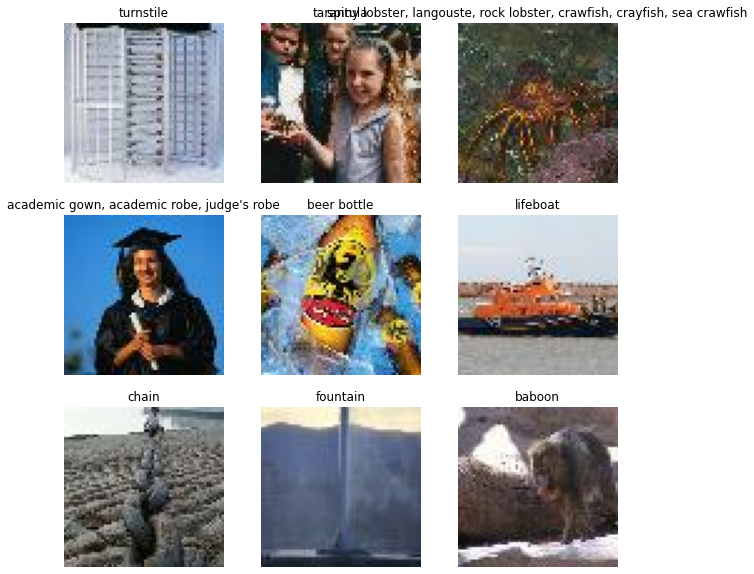

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class_names[labels[i]])
    plt.axis("off")


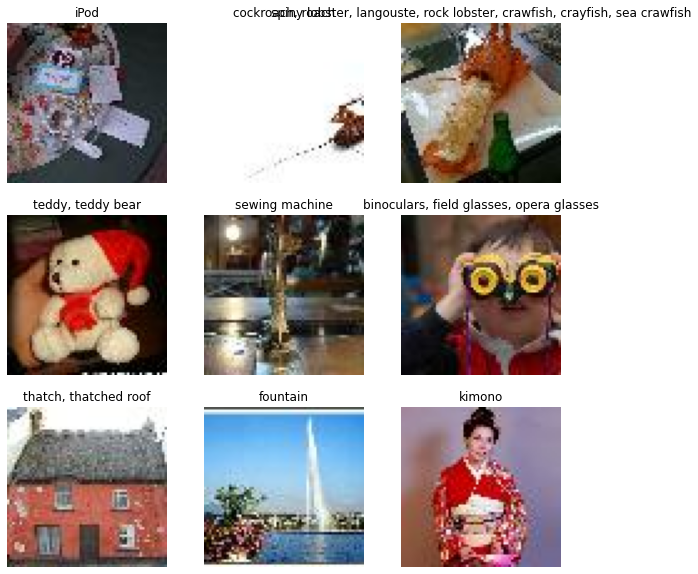

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in val_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(val_class_names[labels[i]])
    plt.axis("off")

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
le = LabelEncoder()
le.fit(train_data.class_names)
train_data.class_names = le.transform(train_data.class_names)

In [20]:
train_data = train_data.map(lambda x,y: (x/63, y))
val_data = val_data.map(lambda x,y: (x/63, y))

In [21]:
train_size = int(len(train_data)*.7)
val_size = int(len(train_data)*.3)

train = train_data.take(train_size)
val = train_data.skip(train_size).take(val_size)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, SeparableConv2D

### Our model from scratch

In [81]:
model = Sequential()

# Original
model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# model.add(Conv2D(8, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(200, activation='softmax'))

In [82]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [83]:
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 6, 6, 256)      

In [84]:
logdir='logs'
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train_data, epochs=100, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/100


2022-11-29 00:26:15.454254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - ETA: 0s - loss: 4.7729 - accuracy: 0.0456

2022-11-29 00:27:15.936104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - 72s 23ms/step - loss: 4.7729 - accuracy: 0.0456 - val_loss: 4.2422 - val_accuracy: 0.1002
Epoch 2/100
3126/3126 [==============================] - 71s 23ms/step - loss: 4.0693 - accuracy: 0.1258 - val_loss: 3.7695 - val_accuracy: 0.1682
Epoch 3/100
3126/3126 [==============================] - 71s 23ms/step - loss: 3.7679 - accuracy: 0.1709 - val_loss: 3.4894 - val_accuracy: 0.2098
Epoch 4/100
3126/3126 [==============================] - 71s 23ms/step - loss: 3.5818 - accuracy: 0.1995 - val_loss: 3.2763 - val_accuracy: 0.2507
Epoch 5/100
3126/3126 [==============================] - 71s 23ms/step - loss: 3.4433 - accuracy: 0.2235 - val_loss: 3.1777 - val_accuracy: 0.2634
Epoch 6/100
3126/3126 [==============================] - 70s 22ms/step - loss: 3.3248 - accuracy: 0.2415 - val_loss: 3.0815 - val_accuracy: 0.2812
Epoch 7/100
3126/3126 [==============================] - 70s 23ms/step - loss: 3.2242 - accuracy: 0.2600 - val_loss: 2.9581 - val_

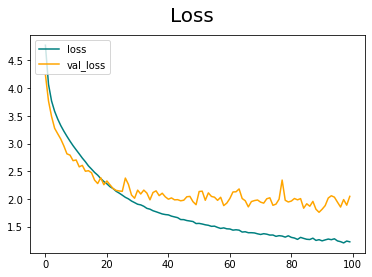

In [85]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

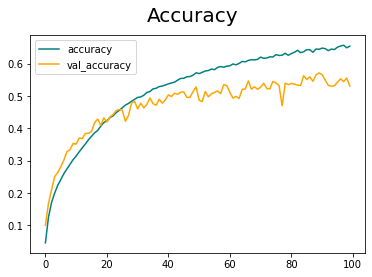

In [86]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [96]:
loss, accuracy = model.evaluate(val_data)

313/313 [==============================] - 3s 9ms/step - loss: 9.4843 - accuracy: 0.1288


## Pre-trained Models

### Xception

In [97]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model

base_model = Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
hist = model.fit(train_data, epochs=20, validation_data=val)

Epoch 1/20


2022-11-29 02:58:19.420176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - ETA: 0s - loss: 4.4528 - accuracy: 0.0845

2022-11-29 03:00:12.514282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - 148s 47ms/step - loss: 4.4528 - accuracy: 0.0845 - val_loss: 3.9968 - val_accuracy: 0.1404
Epoch 2/20
3126/3126 [==============================] - 144s 46ms/step - loss: 4.0222 - accuracy: 0.1356 - val_loss: 3.7479 - val_accuracy: 0.1757
Epoch 3/20
3126/3126 [==============================] - 145s 46ms/step - loss: 3.8693 - accuracy: 0.1579 - val_loss: 3.6466 - val_accuracy: 0.1974
Epoch 4/20
3126/3126 [==============================] - 144s 46ms/step - loss: 3.7494 - accuracy: 0.1781 - val_loss: 3.5240 - val_accuracy: 0.2150
Epoch 5/20
3126/3126 [==============================] - 145s 46ms/step - loss: 3.6363 - accuracy: 0.1961 - val_loss: 3.4145 - val_accuracy: 0.2357
Epoch 6/20
3126/3126 [==============================] - 144s 46ms/step - loss: 3.5214 - accuracy: 0.2175 - val_loss: 3.3707 - val_accuracy: 0.2456
Epoch 7/20
3126/3126 [==============================] - 144s 46ms/step - loss: 3.4147 - accuracy: 0.2383 - val_loss: 3.2615 - val

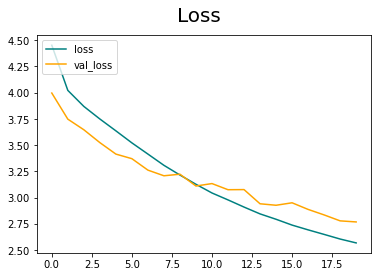

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

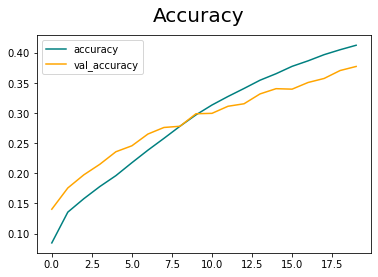

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Resnet50

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False
    
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
hist = model.fit(train_data, epochs=20, validation_data=val)

Epoch 1/20


2022-11-29 03:46:24.242076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - ETA: 0s - loss: 4.4836 - accuracy: 0.0826

2022-11-29 03:47:38.749274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - 99s 31ms/step - loss: 4.4836 - accuracy: 0.0826 - val_loss: 4.0133 - val_accuracy: 0.1432
Epoch 2/20
3126/3126 [==============================] - 95s 30ms/step - loss: 4.0737 - accuracy: 0.1340 - val_loss: 3.7601 - val_accuracy: 0.1825
Epoch 3/20
3126/3126 [==============================] - 95s 30ms/step - loss: 3.8486 - accuracy: 0.1670 - val_loss: 3.5690 - val_accuracy: 0.2162
Epoch 4/20
3126/3126 [==============================] - 95s 30ms/step - loss: 3.6530 - accuracy: 0.1990 - val_loss: 3.4127 - val_accuracy: 0.2430
Epoch 5/20
3126/3126 [==============================] - 95s 30ms/step - loss: 3.4757 - accuracy: 0.2307 - val_loss: 3.2719 - val_accuracy: 0.2688
Epoch 6/20
3126/3126 [==============================] - 95s 30ms/step - loss: 3.3112 - accuracy: 0.2594 - val_loss: 3.1574 - val_accuracy: 0.2893
Epoch 7/20
3126/3126 [==============================] - 95s 30ms/step - loss: 3.1614 - accuracy: 0.2900 - val_loss: 3.0429 - val_accura

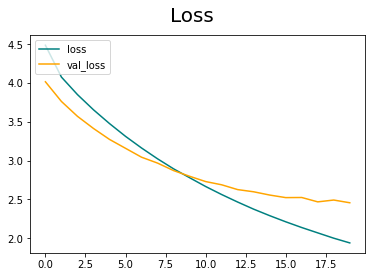

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

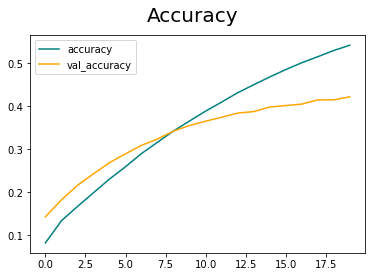

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False
    
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
hist = model.fit(train_data, epochs=20, validation_data=val)

Epoch 1/20


2022-11-29 04:18:06.497438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - ETA: 0s - loss: 3.0558 - accuracy: 0.2955

2022-11-29 04:19:30.811994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - 110s 35ms/step - loss: 3.0558 - accuracy: 0.2955 - val_loss: 2.3418 - val_accuracy: 0.4317
Epoch 2/20
3126/3126 [==============================] - 109s 35ms/step - loss: 2.4863 - accuracy: 0.3974 - val_loss: 1.9755 - val_accuracy: 0.5085
Epoch 3/20
3126/3126 [==============================] - 109s 35ms/step - loss: 2.1815 - accuracy: 0.4586 - val_loss: 1.7371 - val_accuracy: 0.5635
Epoch 4/20
3126/3126 [==============================] - 109s 35ms/step - loss: 1.9098 - accuracy: 0.5185 - val_loss: 1.5499 - val_accuracy: 0.6004
Epoch 5/20
3126/3126 [==============================] - 109s 35ms/step - loss: 1.6634 - accuracy: 0.5732 - val_loss: 1.3933 - val_accuracy: 0.6358
Epoch 6/20
3126/3126 [==============================] - 109s 35ms/step - loss: 1.4434 - accuracy: 0.6245 - val_loss: 1.2638 - val_accuracy: 0.6603
Epoch 7/20
3126/3126 [==============================] - 109s 35ms/step - loss: 1.2523 - accuracy: 0.6690 - val_loss: 1.1555 - val

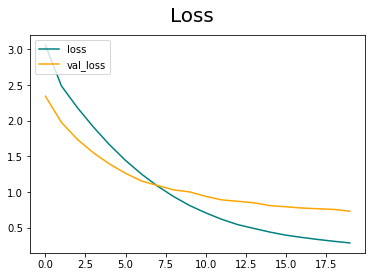

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

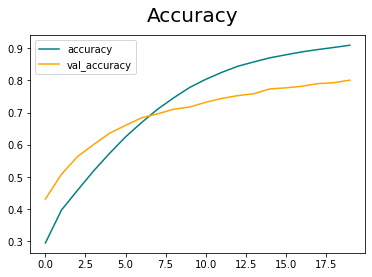

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### EfficientNet-B7

In [107]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

base_model = EfficientNetB7(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional EfficientNetB7 layers
for layer in base_model.layers:
    layer.trainable = False
    
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
hist = model.fit(train_data, epochs=20, validation_data=val)

Epoch 1/20


2022-11-29 07:11:16.169044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - ETA: 0s - loss: 5.3048 - accuracy: 0.0042

2022-11-29 07:15:54.487902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - 368s 113ms/step - loss: 5.3048 - accuracy: 0.0042 - val_loss: 5.2976 - val_accuracy: 0.0058
Epoch 2/20
3126/3126 [==============================] - 349s 112ms/step - loss: 5.2996 - accuracy: 0.0044 - val_loss: 5.2975 - val_accuracy: 0.0058
Epoch 3/20
3126/3126 [==============================] - 342s 109ms/step - loss: 5.2994 - accuracy: 0.0041 - val_loss: 5.2974 - val_accuracy: 0.0058
Epoch 4/20
3126/3126 [==============================] - 339s 108ms/step - loss: 5.2986 - accuracy: 0.0041 - val_loss: 5.2974 - val_accuracy: 0.0059
Epoch 5/20
3126/3126 [==============================] - 1793s 574ms/step - loss: 5.2984 - accuracy: 0.0041 - val_loss: 5.2974 - val_accuracy: 0.0059
Epoch 6/20
3126/3126 [==============================] - 350s 112ms/step - loss: 5.2983 - accuracy: 0.0044 - val_loss: 5.2974 - val_accuracy: 0.0058
Epoch 7/20
3126/3126 [==============================] - 344s 110ms/step - loss: 5.2986 - accuracy: 0.0041 - val_loss: 5.29

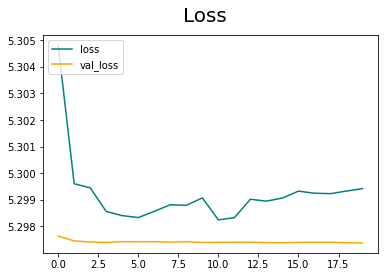

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

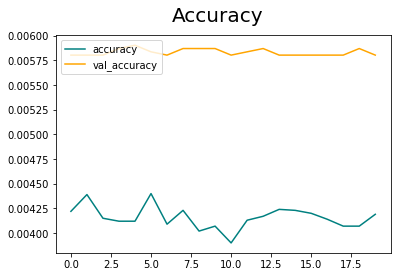

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### EfficientNet-v2B3

In [110]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3

base_model = EfficientNetV2B3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional EfficientNetV2B3 layers
for layer in base_model.layers:
    layer.trainable = False
    
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
hist = model.fit(train_data, epochs=20, validation_data=val)

Epoch 1/20


2022-11-29 21:01:32.012763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - ETA: 0s - loss: 4.7668 - accuracy: 0.0476

2022-11-29 21:03:47.372083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - 179s 55ms/step - loss: 4.7668 - accuracy: 0.0476 - val_loss: 4.4599 - val_accuracy: 0.0797
Epoch 2/20
3126/3126 [==============================] - 159s 51ms/step - loss: 4.4340 - accuracy: 0.0836 - val_loss: 4.2798 - val_accuracy: 0.1044
Epoch 3/20
3126/3126 [==============================] - 163s 52ms/step - loss: 4.3187 - accuracy: 0.0990 - val_loss: 4.2109 - val_accuracy: 0.1135
Epoch 4/20
3126/3126 [==============================] - 161s 52ms/step - loss: 4.2510 - accuracy: 0.1093 - val_loss: 4.1214 - val_accuracy: 0.1260
Epoch 5/20
3126/3126 [==============================] - 162s 52ms/step - loss: 4.2069 - accuracy: 0.1154 - val_loss: 4.1315 - val_accuracy: 0.1221
Epoch 6/20
3126/3126 [==============================] - 163s 52ms/step - loss: 4.1716 - accuracy: 0.1200 - val_loss: 4.0670 - val_accuracy: 0.1331
Epoch 7/20
3126/3126 [==============================] - 161s 51ms/step - loss: 4.1410 - accuracy: 0.1260 - val_loss: 4.0535 - val

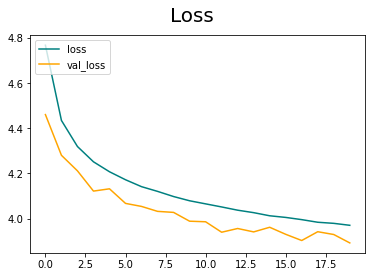

In [111]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

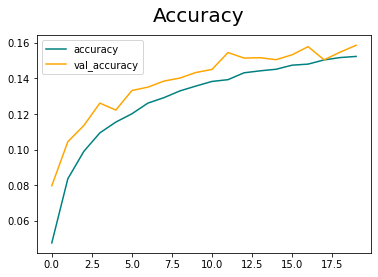

In [112]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()